# Installing dependencies and loading

In [22]:
!pip install pandas --quiet
!pip install torchtext --quiet
     

In [23]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import requests, zipfile, io
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [11]:
# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)
df = df.sample(frac = .1).reset_index()
df['polarity'] = (df.polarity.values > 1).astype(int)

# Let's have a look at it
df.head()
     

,index,polarity,id,date,query,user,text
0,267346,0,1989177939,Mon Jun 01 00:36:31 PDT 2009,NO_QUERY,BOMBkid,"@MISTA23 gosh, i know. i've watched most of th..."
1,1234779,1,1992457075,Mon Jun 01 08:47:04 PDT 2009,NO_QUERY,Duzaman,"Ok, I'm all ready for E3. Twitter page up, che..."
2,124172,0,1834056178,Mon May 18 01:27:41 PDT 2009,NO_QUERY,landay92,i have got a free lesson wooo!!!!!!!! im bored...
3,23993,0,1557872397,Sun Apr 19 06:22:36 PDT 2009,NO_QUERY,dalesman47,"Avocets are ar RSPB Conwy, and an Osprey flew ..."
4,197533,0,1971022829,Sat May 30 05:59:28 PDT 2009,NO_QUERY,hash_iphone,@logicattraction @Sean_T_Wright sadly it refus...


In [6]:
print("Dataset size:", len(df))


Dataset size: 160000


Mapping target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [7]:
df.polarity

0         0
1         1
2         1
3         0
4         0
         ..
159995    1
159996    1
159997    0
159998    1
159999    0
Name: polarity, Length: 160000, dtype: int64

In [8]:
from collections import Counter
import seaborn as sns

In [9]:
target_cnt = Counter(df.polarity)

Text(0, 0.5, 'Number of examples')

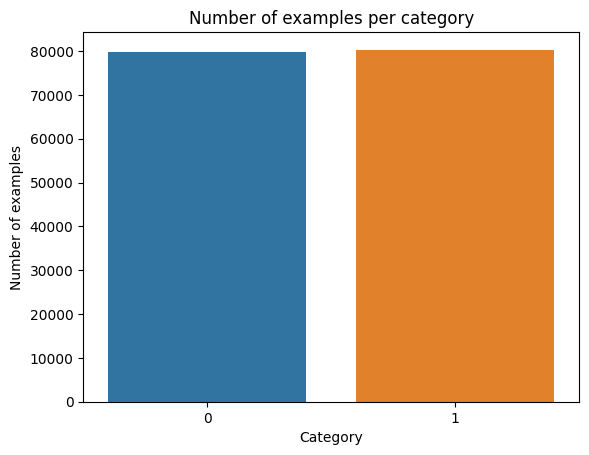

In [10]:
ax = sns.barplot(x=list(target_cnt.keys()),y=list(target_cnt.values()))
ax.set_title('Number of examples per category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of examples")

# Preprocessing step

In [12]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
stop_words = stopwords.words("english")
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused'}

In [14]:
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()

    for txt in textdata:
        txt = txt.lower()
        txt = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' URL',txt)
        for emoji in emojis.keys():
            txt = txt.replace(emoji, "EMOJI" + emojis[emoji])        
        txt = re.sub('@[^\s]+',' USER', txt)        
        txt = re.sub("[^a-zA-Z0-9]", " ", txt)
        txt = re.sub(r"(.)\1\1+", r"\1\1", txt)
        tweetwords = ''
        for word in tweet.split():
            if word not in stop_words:
              if len(word)>1:
                  word = wordLemm.lemmatize(word)
                  tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [16]:
df["text_processed"] = preprocess(df["text"])

# **Part 1 : RNN** 

### Glove

In [45]:
import torchtext
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

glove = torchtext.vocab.GloVe(name="6B", dim=50)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:08<00:00, 45818.74it/s]


In [91]:
df.text = df.text.str.lower()
df.text = df.text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
df.text = df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
df.text = df.text.apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))
df.text = df.text.apply(lambda x: re.sub('@[^\s]+', '', x))
lemmatizer = WordNetLemmatizer()
input_tmp = [[lemmatizer.lemmatize(token) 
                    for token in word_tokenize(text) if token not in stop_words] 
                        for text in df.text]
y = df["polarity"]

In [92]:
input_token_indexes = [[glove.stoi[token] 
                          for token in row if token in glove.stoi] 
                              for row in input_tmp ]
output = [torch.tensor(int(row)).long() for row in y]
input = []
for row in input_token_indexes:
  pad_size = 39 - len(row)
  input.append([0]*pad_size + row)
input = np.array(input)

In [93]:
x_train, x_test, y_train, y_test = train_test_split(input, output ,random_state=78, test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train ,random_state=78, test_size=0.1, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_train), torch.tensor(y_train)), batch_size=32, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_val), torch.tensor(y_val)), batch_size=32, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_test), torch.tensor(y_test)), batch_size=32, shuffle=True, drop_last=True)

In [95]:
def acc(model, data_loader):
    correct, total = 0, 0
    for texts, labels in data_loader:
        output = model(texts)
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        total += labels.shape[0]
    return correct / total

def train(model, opt, criterion, train, val):
    for texts, labels in train:
        opt.zero_grad()
        pred = model(texts)
        loss = criterion(pred, labels)
        loss.backward()
        opt.step()
    train_accuracy = acc(model, train)
    validation_accuracy = acc(model, val)
    return float(loss), train_accuracy, validation_accuracy

In [96]:
class myRNN_glove(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(myRNN_glove, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

Epoch: 1 loss: 0.5993395447731018 train accuracy: 0.6687345679012345
Epoch: 2 loss: 0.6725987195968628 train accuracy: 0.6716898148148148
Epoch: 3 loss: 0.479489266872406 train accuracy: 0.6858487654320987
Epoch: 4 loss: 0.6443220376968384 train accuracy: 0.6964351851851852
Epoch: 5 loss: 0.5919008851051331 train accuracy: 0.7037654320987654
Epoch: 6 loss: 0.6449365615844727 train accuracy: 0.7129783950617284
Epoch: 7 loss: 0.5297423005104065 train accuracy: 0.7169367283950617
Epoch: 8 loss: 0.6116867065429688 train accuracy: 0.7230092592592593
Epoch: 9 loss: 0.5857399106025696 train accuracy: 0.7229012345679012
Epoch: 10 loss: 0.5884416103363037 train accuracy: 0.7282098765432099
Epoch: 11 loss: 0.6575352549552917 train accuracy: 0.727229938271605
Epoch: 12 loss: 0.54320228099823 train accuracy: 0.730679012345679


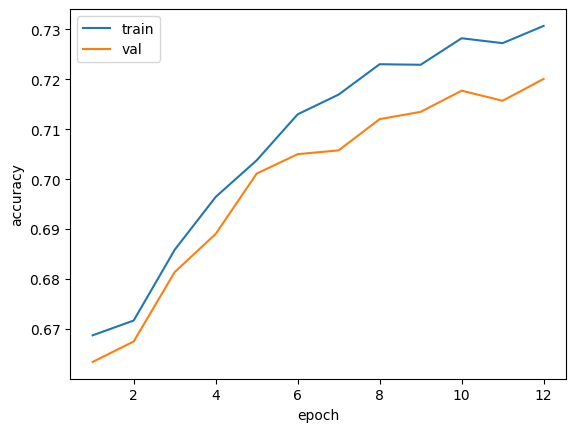

In [97]:
model = myRNN_glove(50, 38, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
losses, train_acc, valid_acc, epochs = [], [], [], []

for i in range(12):
  loss, train_accuracy, validation_accuracy = train(model, optimizer, criterion, train_dataloader, val_dataloader)
  print(f"Epoch: {i + 1} loss: {loss} train accuracy: {train_accuracy}")
  losses.append(loss)
  train_acc.append(train_accuracy)
  valid_acc.append(validation_accuracy)
  epochs.append(i + 1)

plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, valid_acc, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

In [99]:
import torch

# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a tensor
x = torch.tensor([1, 2, 3])

# Move the tensor to the GPU
x = x.to(device)

# Perform an operation on the tensor
y = x + 1

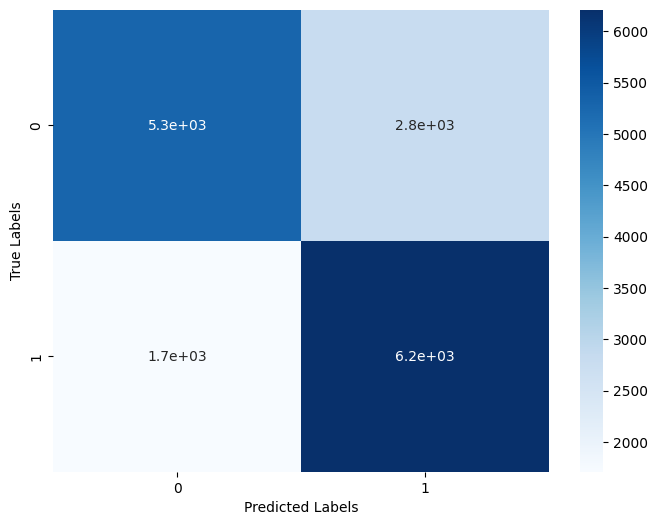

In [101]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the test data loader and the trained model

# Set the model to evaluation mode and move it to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Initialize the true labels and predicted labels arrays
true_labels = np.array([])
pred_labels = np.array([])

# Iterate over the test data loader and collect the true and predicted labels
for data, labels in test_dataloader:
    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    true_labels = np.concatenate((true_labels, labels.cpu().numpy()))
    pred_labels = np.concatenate((pred_labels, predicted.cpu().numpy()))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Word2Vec

In [113]:
from gensim.models import Word2Vec
word2vec = Word2Vec(input_tokens, min_count=2, vector_size=25)

In [114]:
class myRNN_w2v(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(myRNN_w2v, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [115]:

output = df["polarity"]
input_token_vectors = [[word2vec.wv[token] 
                          for token in row if token in word2vec.wv] 
                              for row in input_tmp]
output = [torch.tensor(int(row)).long() for row in output]
input = []
for row in input_token_vectors:
  pad_size = 30 - len(row)
  if len(row):
    input.append(np.concatenate((np.zeros((pad_size, 25)), np.array(row)) , axis=0))
  else:
    input.append(np.zeros((pad_size, 25)))
input = np.array(input).astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(input, output ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)

train_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_train), torch.tensor(y_train)), batch_size=32, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_val), torch.tensor(y_val)), batch_size=32, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_test), torch.tensor(y_test)), batch_size=32, shuffle=True, drop_last=True)


Epoch: 1 loss: 0.5223268866539001 train accuracy: 0.7113117283950617 
Epoch: 2 loss: 0.6023440957069397 train accuracy: 0.722662037037037 
Epoch: 3 loss: 0.607255220413208 train accuracy: 0.7280478395061728 
Epoch: 4 loss: 0.500192403793335 train accuracy: 0.7285725308641975 
Epoch: 5 loss: 0.5352129340171814 train accuracy: 0.7268055555555556 
Epoch: 6 loss: 0.5140281319618225 train accuracy: 0.736195987654321 
Epoch: 7 loss: 0.5185447931289673 train accuracy: 0.7392824074074074 
Epoch: 8 loss: 0.5812908411026001 train accuracy: 0.7370447530864197 
Epoch: 9 loss: 0.4474444091320038 train accuracy: 0.7416898148148148 
Epoch: 10 loss: 0.5572702884674072 train accuracy: 0.744128086419753 


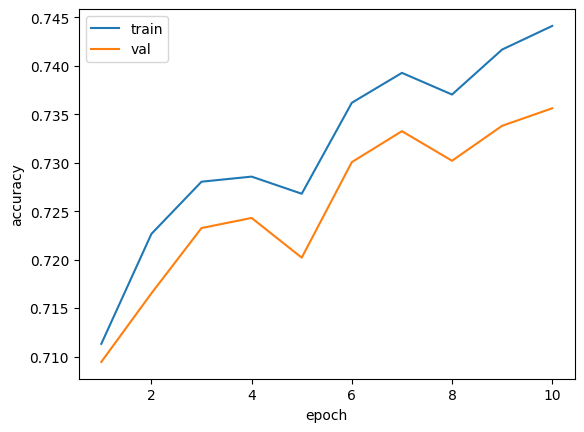

In [116]:
model = myRNN_w2v(25, 26, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
losses, train_acc, valid_acc, epochs = [], [], [], []

for i in range(10):
  loss, train_accuracy, validation_accuracy = train(model, optimizer, criterion, train_dataloader, val_dataloader)
  print(f"Epoch: {i + 1} loss: {loss} train accuracy: {train_accuracy} ")
  losses.append(loss)
  train_acc.append(train_accuracy)
  valid_acc.append(validation_accuracy)
  epochs.append(i + 1)



plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, valid_acc, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

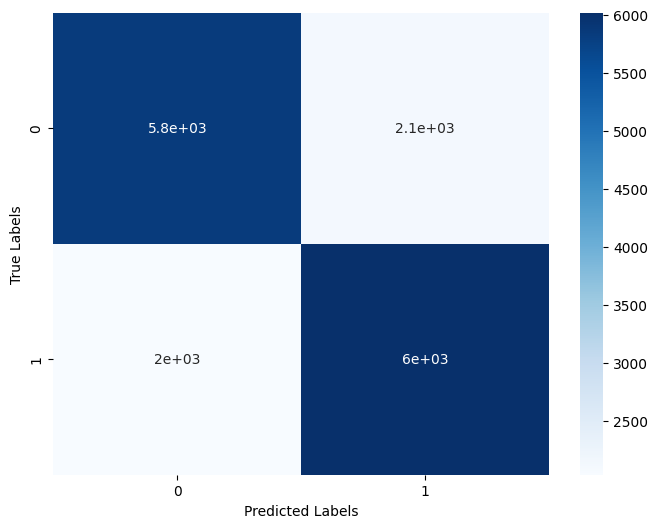

In [117]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the test data loader and the trained model

# Set the model to evaluation mode and move it to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Initialize the true labels and predicted labels arrays
true_labels = np.array([])
pred_labels = np.array([])

# Iterate over the test data loader and collect the true and predicted labels
for data, labels in test_dataloader:
    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    true_labels = np.concatenate((true_labels, labels.cpu().numpy()))
    pred_labels = np.concatenate((pred_labels, predicted.cpu().numpy()))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### One-hot

In [ ]:
X = df.text.values

# Changes values from [0,4] to [0,1]
y = df.polarity.values 


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

tokenizer = get_tokenizer("basic_english")

x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

In [18]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 126659
['.', 'i', '!', "'", 'to', 'the', ',', 'a', 'my', 'and', 'it', 'you', '?', 'is', 'in', 'for', 'of', 's', 't', 'on', 'that', 'me', 'so', 'have', 'm', 'but', 'just', 'with', 'be', 'at', 'not', 'was', 'now', 'this', 'can', 'good', 'up', 'all', 'out', 'day', 'get', 'are', 'like', 'no', 'go', 'http', '-', 'today', 'going', 'do', 'your', 'love', 'we', 'too', 'work', 'got', 'what', 'lol', 'time', 'back', 'u', 'from', 'one', 'will', 'know', 'about', 'don', 'am', 'im', 'really', 'had', ')', 'see', 'some', 'its', 'there', 'they', '&amp', 'still', 'how', 'well', 'if', 'night', 'new', '&quot', '(', 'think', 'want', 'home', 'll', 'thanks', 'when', 'oh', 'he', '2', 'here', 'as', 'more', 'much', 'last']


In [19]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 0.7366235324769657% most common words account for the 80.00093332874525% of the occurrences


In [20]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

# Set the device (check if gpu is available)
device = set_device()

Let's select only the most used.

In [21]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

In [24]:
# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}


# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word


Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. These sequences of indexes will be the input to our pytorch model.

In [25]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

We need all the sequences to have the same length. To select an adequate sequence length, let's explore some statistics about the length of the tweets:

In [26]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  229
Mean tweet word length:  15.0
99% percent under:  36.0


In [27]:
 # We choose the max length
 max_length = 40

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
 def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet)
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features


# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [37]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [38]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 150

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25


In [31]:
class rnn_Onehot(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(rnn_Onehot, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.embedding(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out



def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [39]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.569969; Train Acc 0.715242; Val Acc 0.707875
Epoch 2; Loss 0.439393; Train Acc 0.762383; Val Acc 0.749844
Epoch 3; Loss 0.489619; Train Acc 0.782570; Val Acc 0.764250
Epoch 4; Loss 0.424837; Train Acc 0.797961; Val Acc 0.773937
Epoch 5; Loss 0.464518; Train Acc 0.810195; Val Acc 0.778250


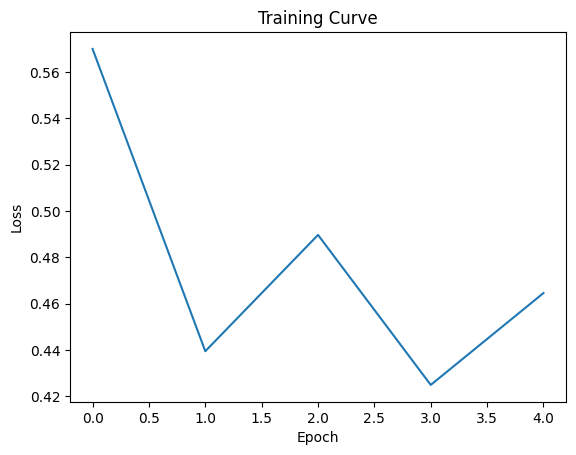

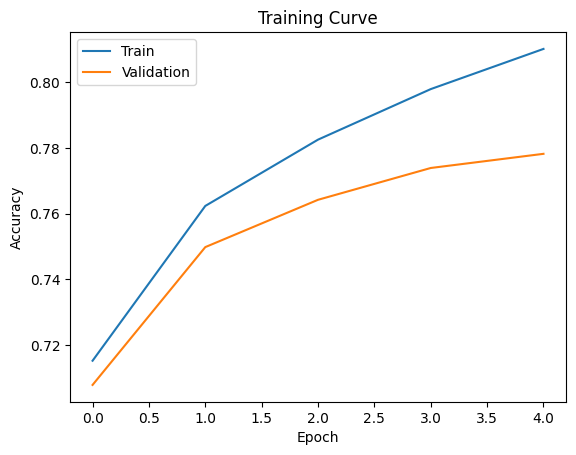

0.77825

In [40]:
model = rnn_Onehot(150, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model, test_loader)

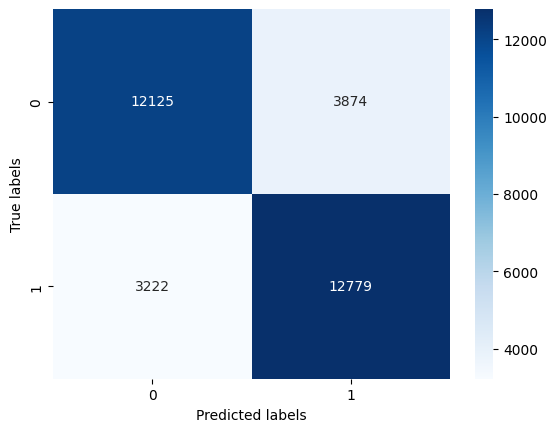

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#**Part 2 : LSTM & GRU** 

## LSTM for Long-Term Dependencies


### GLove

In [102]:
class myLSTM_glove(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(myLSTM_glove, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Epoch: 1 loss: 0.6800597310066223 train accuracy: 0.6863194444444445 
Epoch: 2 loss: 0.5281124711036682 train accuracy: 0.7041820987654321 
Epoch: 3 loss: 0.5541554093360901 train accuracy: 0.7192206790123457 
Epoch: 4 loss: 0.577830970287323 train accuracy: 0.7280015432098765 
Epoch: 5 loss: 0.5819714665412903 train accuracy: 0.7326697530864198 
Epoch: 6 loss: 0.5371913909912109 train accuracy: 0.7394444444444445 
Epoch: 7 loss: 0.5784478187561035 train accuracy: 0.7420138888888889 
Epoch: 8 loss: 0.4903733432292938 train accuracy: 0.7435648148148148 
Epoch: 9 loss: 0.6497226357460022 train accuracy: 0.7476003086419754 
Epoch: 10 loss: 0.3877451717853546 train accuracy: 0.7489351851851852 
Epoch: 11 loss: 0.4753020703792572 train accuracy: 0.7526003086419754 
Epoch: 12 loss: 0.4369406998157501 train accuracy: 0.7546141975308642 


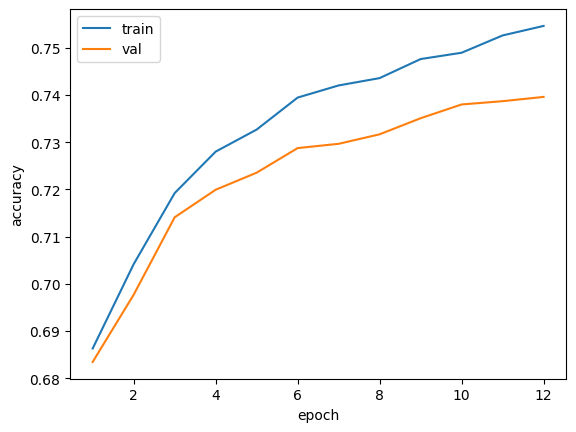

In [104]:
model = myLSTM_glove(50, 26, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

losses, train_acc, valid_acc, epochs = [], [], [], []

for i in range(12):
  loss, train_accuracy, validation_accuracy = train_one_epoch(model, optimizer, criterion, train_dataloader, val_dataloader)
  print(f"Epoch: {i + 1} loss: {loss} train accuracy: {train_accuracy} ")
  losses.append(loss)
  train_acc.append(train_accuracy)
  valid_acc.append(validation_accuracy)
  epochs.append(i + 1)


plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, valid_acc, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

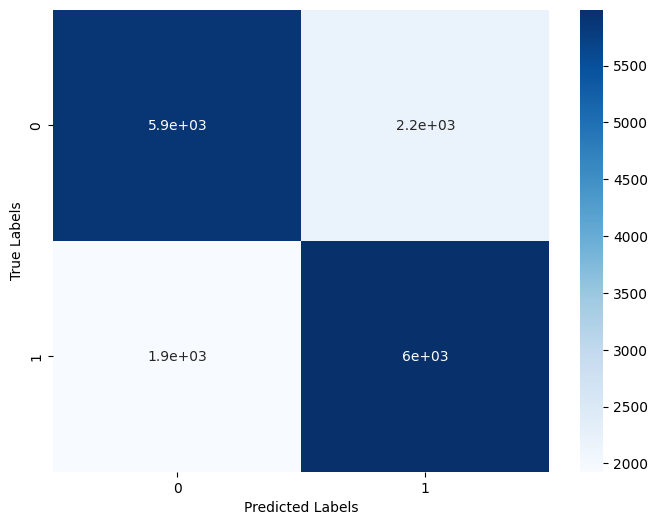

In [105]:
# Set the model to evaluation mode and move it to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Initialize the true labels and predicted labels arrays
true_labels = np.array([])
pred_labels = np.array([])

# Iterate over the test data loader and collect the true and predicted labels
for data, labels in test_dataloader:
    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    true_labels = np.concatenate((true_labels, labels.cpu().numpy()))
    pred_labels = np.concatenate((pred_labels, predicted.cpu().numpy()))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### One-Hot encoding

In [42]:
class LSTM_onehot(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM_onehot, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Epoch 1; Loss 0.607686; Train Acc 0.615742; Val Acc 0.614094
Epoch 2; Loss 0.626350; Train Acc 0.632883; Val Acc 0.625375
Epoch 3; Loss 0.587605; Train Acc 0.677789; Val Acc 0.669906
Epoch 4; Loss 0.571659; Train Acc 0.691844; Val Acc 0.683781
Epoch 5; Loss 0.609581; Train Acc 0.701820; Val Acc 0.690531


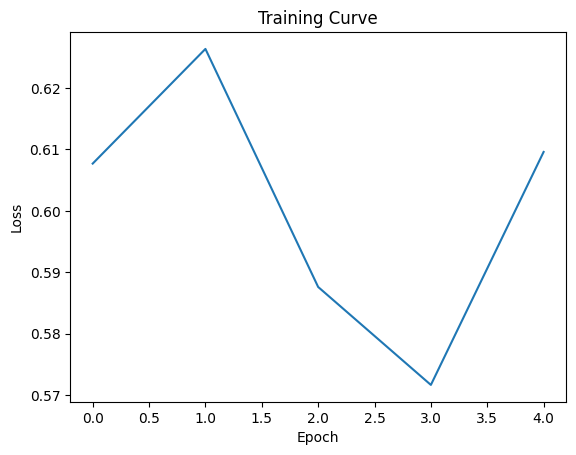

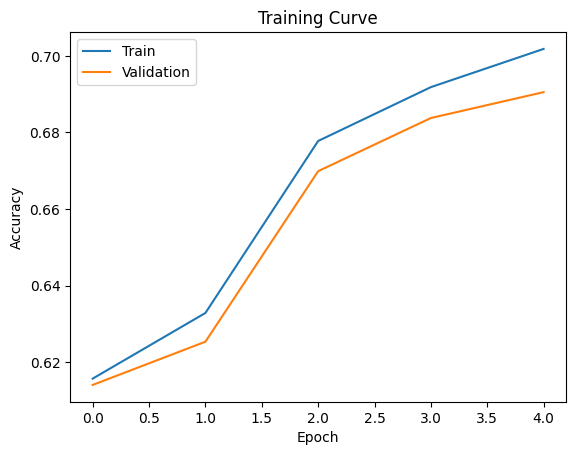

0.69053125

In [51]:
model_lstm = LSTM_onehot(50, 150, 2)
train_rnn_network(model_lstm, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model_lstm, test_loader)

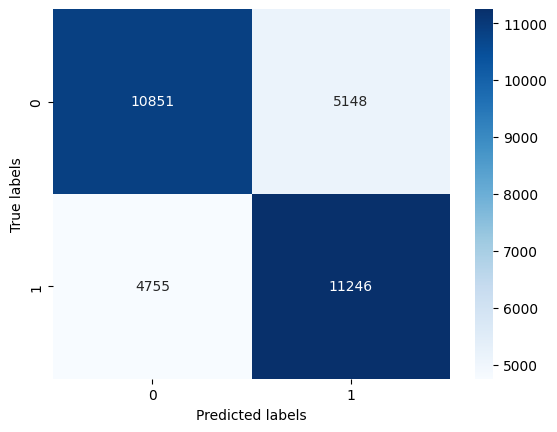

In [52]:
model_lstm.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_lstm(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## GRU for Long-Term Dependencies¶


### Glove

In [106]:
class myGRU_glove(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(myGRU_glove, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

      

Epoch: 1 loss: 0.5602394342422485 train accuracy: 0.6866975308641975
Epoch: 2 loss: 0.5930778980255127 train accuracy: 0.7078086419753087
Epoch: 3 loss: 0.5491670370101929 train accuracy: 0.7185108024691358
Epoch: 4 loss: 0.7013236880302429 train accuracy: 0.7279166666666667
Epoch: 5 loss: 0.5245728492736816 train accuracy: 0.7324151234567902
Epoch: 6 loss: 0.6339565515518188 train accuracy: 0.7368827160493827
Epoch: 7 loss: 0.48236608505249023 train accuracy: 0.7400617283950617
Epoch: 8 loss: 0.527616024017334 train accuracy: 0.740462962962963
Epoch: 9 loss: 0.4706561863422394 train accuracy: 0.7465972222222222
Epoch: 10 loss: 0.4694577753543854 train accuracy: 0.7456867283950618
Epoch: 11 loss: 0.5228255987167358 train accuracy: 0.7486651234567901
Epoch: 12 loss: 0.4236438274383545 train accuracy: 0.7517901234567901


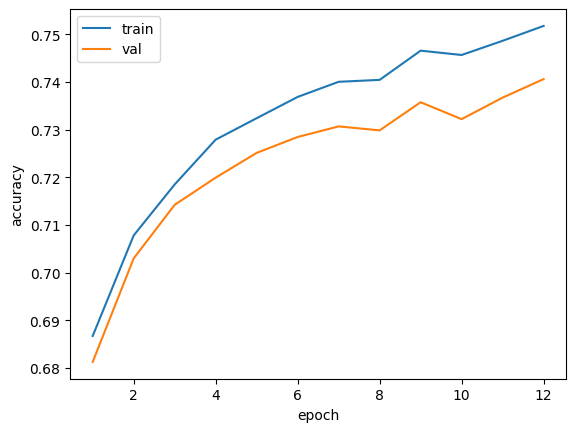

In [107]:
model = myGRU_glove(50, 26, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

losses, train_acc, valid_acc, epochs = [], [], [], []

for i in range(12):
  loss, train_accuracy, validation_accuracy = train_one_epoch(model, optimizer, criterion, train_dataloader, val_dataloader)
  print(f"Epoch: {i + 1} loss: {loss} train accuracy: {train_accuracy}")
  losses.append(loss)
  train_acc.append(train_accuracy)
  valid_acc.append(validation_accuracy)
  epochs.append(i + 1)

plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, valid_acc, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

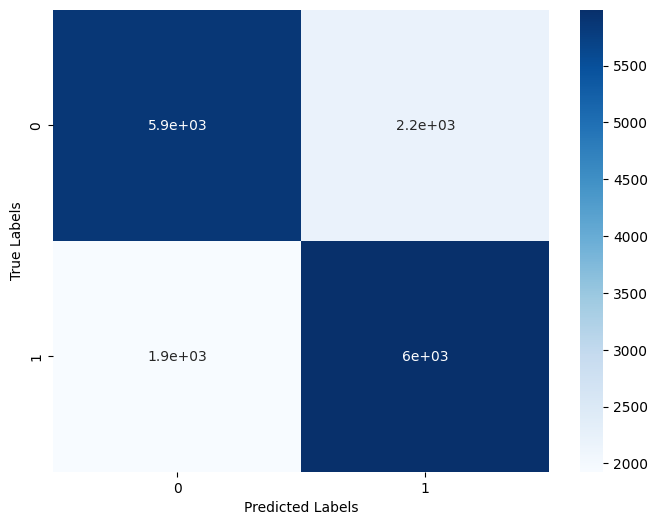

In [108]:

# Set the model to evaluation mode and move it to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Initialize the true labels and predicted labels arrays
true_labels = np.array([])
pred_labels = np.array([])

# Iterate over the test data loader and collect the true and predicted labels
for data, labels in test_dataloader:
    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    true_labels = np.concatenate((true_labels, labels.cpu().numpy()))
    pred_labels = np.concatenate((pred_labels, predicted.cpu().numpy()))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### One-hot

In [53]:
class GRU_onehot(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRU_onehot, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

Epoch 1; Loss 0.607113; Train Acc 0.747961; Val Acc 0.741313
Epoch 2; Loss 0.404945; Train Acc 0.779875; Val Acc 0.765125
Epoch 3; Loss 0.399437; Train Acc 0.800859; Val Acc 0.775719
Epoch 4; Loss 0.436240; Train Acc 0.811844; Val Acc 0.782344
Epoch 5; Loss 0.419956; Train Acc 0.825586; Val Acc 0.788344


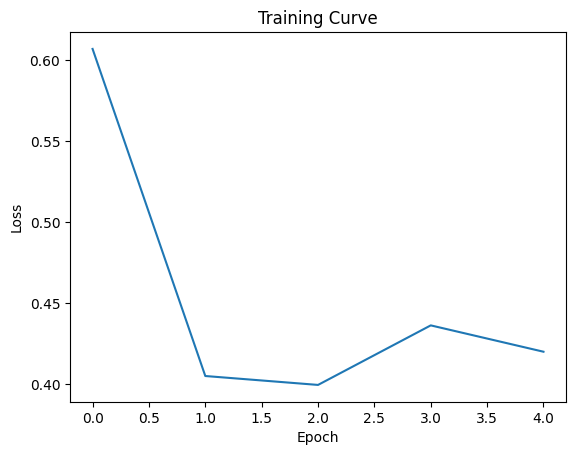

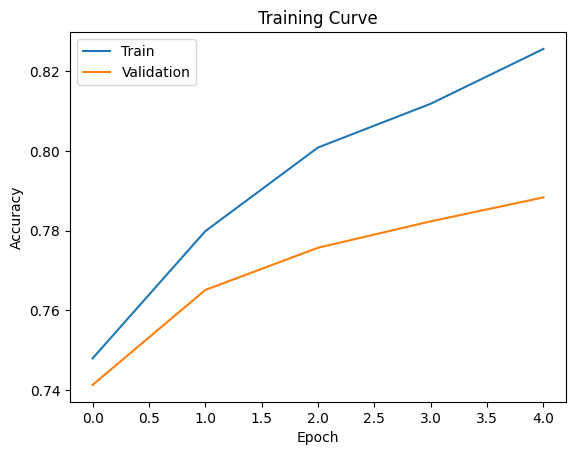

0.78834375

In [56]:
model_GRU = GRU_onehot(150, 50, 2)
train_rnn_network(model_GRU, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4)
get_accuracy(model_GRU, test_loader)

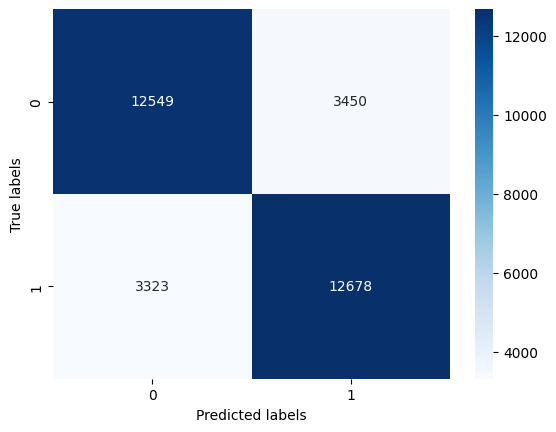

In [57]:
model_GRU.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_GRU(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()